### Is it a bird? Creating a Model From Your Own Data

FastAI Course - Lesson 01: https://course.fast.ai/Lessons/lesson1.html 

Notebook - Lesson 01: https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data

#### Step 1: Download images of birds

In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

In [3]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

Searching for 'bird photos'
https://images.alphacoders.com/492/492674.jpg


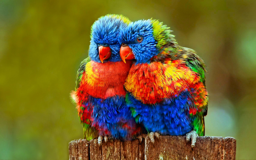

In [4]:
bird_img_urls = search_images('bird photos', max_images=1)
bird_img_url = bird_img_urls[0]
print(bird_img_url)
dest = Path('bird.jpg')
if not dest.exists(): download_url(bird_img_url, dest, show_progress=False)
birth_img = Image.open(dest)
birth_img.to_thumb(256, 256)

Searching for 'forest photos'
http://wallpapercave.com/wp/6nUx8Ku.jpg


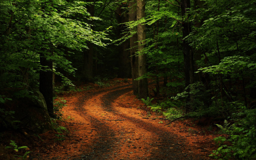

In [5]:
forest_img_urls = search_images('forest photos', max_images=1)
forest_img_url = forest_img_urls[0]
print(forest_img_url)
dest = Path('forest.jpg')
if not dest.exists(): download_url(forest_img_url, dest, show_progress=False)
forest_img = Image.open(dest)
forest_img.to_thumb(256, 256)

In [15]:
searches = ['forest', 'bird']
path = Path('bird_or_not')
if not path.exists():
    for search in searches:
        dest = (path/search)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{search} photo'))
        sleep(10)
        download_images(dest, urls=search_images(f'{search} sun photo'))
        sleep(10)
        download_images(dest, urls=search_images(f'{search} shade photo'))
        sleep(10)
        resize_images(path/search, max_size=400, dest=path/search)
else:
    print('Images already exist. If new images are desired, delete the directory and re-run cell')


Images already exist. If new images are desired, delete the directory and re-run cell


#### Step 2: Train the Model

Remove images that failed to download correctly

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

Training a model with `fastai` uses `DataLoaders`, which is an object that contains a _training set_ and a _validation set_

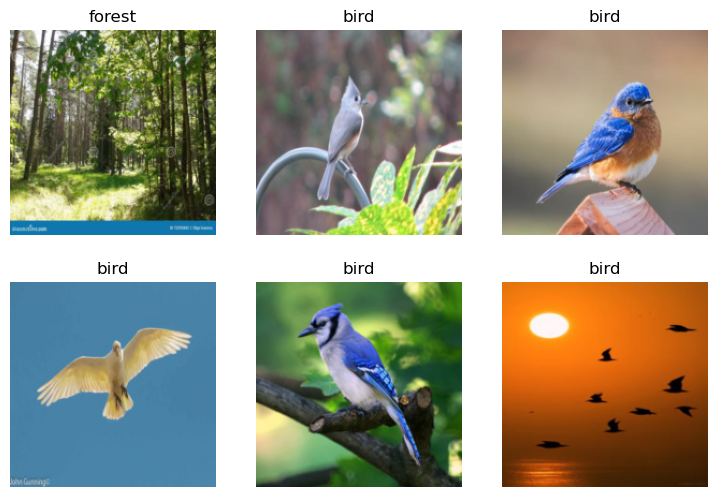

In [12]:
dls = DataBlock(
    # inputs are images, outputs are categories
    blocks=(ImageBlock, CategoryBlock),
    # find all the inputs for the model
    get_items=get_image_files,
    # split the data into training and validation sets randomly, using 20% of the
    # data for the validation set
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    # before training, resize each image to 192x192 pixels by "squishing", rather than
    # cropping
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now to train the model. `resnet18` is the fastest computer vision model. It can be trained in about ~10 seconds

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories)

Using `fastai`, there is a helpful `fine_tine()` method which automatically uses best practices for fine tuning a pre-trained model

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/charlie/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.901270,0.694009,0.242424,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.286374,0.089415,0.030303,00:02
1,0.145102,0.030008,0.030303,00:00
2,0.100509,0.025860,0.000000,00:00


In [14]:
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9999


In the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!